In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from libs.utils import montage

from libs import gif
import IPython.display as ipyd
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from libs.datasets import MNIST

ds = MNIST()

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
ds.X.shape

(70000, 784)

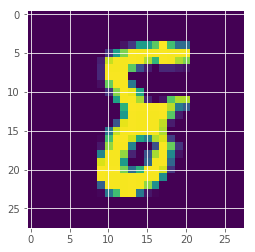

In [6]:
plt.imshow(np.reshape(ds.X[0],(28,28)))

In [7]:
imgs = ds.X[:1000].reshape((-1,28,28))

In [8]:
imgs.shape

(1000, 28, 28)

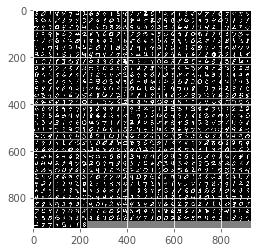

In [9]:
plt.imshow(montage(imgs), cmap='gray')

In [10]:
mean_img = np.mean(ds.X, axis=0)

In [11]:
plt.figure()

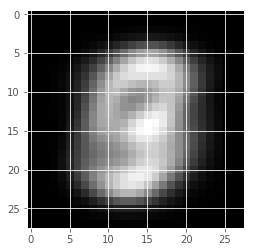

In [13]:
plt.imshow(np.reshape(mean_img,(28,28)), cmap='gray')

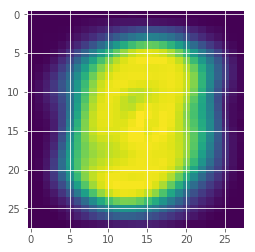

In [14]:
std_img = np.std(ds.X, axis=0)

plt.figure()
plt.imshow(np.reshape(std_img, (28,28)))

In [15]:
#autoencoding

dimensions = [512,256,128,64]

In [16]:
n_features = ds.X.shape[1] #784

X = tf.placeholder(tf.float32, shape=(None, n_features))

In [17]:
current_input = X
n_input = n_features

Ws = []

for layer_i,n_output in enumerate(dimensions):
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        W = tf.get_variable(
                name='W',
                shape=[n_input, n_output],
                initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
            )
        h = tf.matmul(current_input, W)
        
        current_input = tf.nn.relu(h)
        
        Ws.append(W)
        
        n_input = n_output

In [18]:
print(current_input.get_shape().as_list())

[None, 64]


In [40]:
# reverse everything to get back to original image

Ws = Ws[::-1]

dimensions = dimensions[::-1][1:] + [ds.X.shape[1]]
print(dimensions)

[128, 256, 512, 784]


In [37]:
a= [1,2,2,3,3,5,43,2]

In [38]:
a = a[::-1]

In [39]:
a

[2, 43, 5, 3, 3, 2, 2, 1]

In [42]:
# create reversed layers

for layer_i, output_i in enumerate(dimensions):
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        W = tf.transpose(Ws[layer_i])
        h = tf.matmul(current_input,W)
        
        current_input = tf.nn.relu(h)
        
        n_input = n_output

In [43]:
Y = current_input

In [44]:
current_input.get_shape()

TensorShape([Dimension(None), Dimension(784)])

In [45]:
# cost function

cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)
print(cost.get_shape())

(?,)


In [46]:
cost = tf.reduce_mean(cost) #take across batches for one scalar in the end

In [47]:
print(cost.get_shape())

()


In [48]:
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [49]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0 0.0417243
1 0.0370311
2 0.0334777
3 0.0328586
4 0.0308088


C:\Users\itpstudent\Miniconda3\envs\tensorflow\lib\site-packages\matplotlib\animation.py:971: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


RuntimeError: Error creating movie, return code: 1 Try setting mpl.verbose.set_level("helpful")

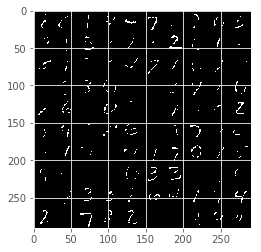

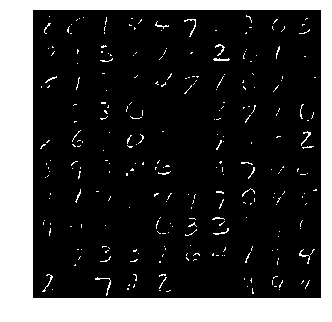

In [50]:
batch_size = 100
n_epochs = 5

examples = ds.X[:100]

imgs = [] # reconstructed images
fig, ax = plt.subplots(1,1)

for epoch_i in range(n_epochs):
    for batch_x, _ in ds.train.next_batch():
        sess.run(optimizer, feed_dict={X: batch_x - mean_img})
    
    recon = sess.run(Y, feed_dict={X:examples-mean_img})
    recon = np.clip((recon+mean_img).reshape((-1,28,28)),0,255)
    img_i = montage(recon).astype(np.uint8)
    imgs.append(img_i)
    ax.imshow(img_i, cmap='gray')
    fig.canvas.draw()
    print(epoch_i,sess.run(cost, feed_dict={X:batch_x-mean_img}))

gif.build_gif(imgs, saveto='ae2.gif', cmap='gray')

In [51]:
from tensorflow.python.framework.ops import reset_default_graph

In [52]:
reset_default_graph()